In [1]:
import pickle
import clip
import socket
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

print("Hostname: " + socket.gethostname())
print("Torch version:", torch.__version__)

Hostname: sx-el-121920
Torch version: 1.13.0a0+d0d6b1f


# configuration

In [2]:
SIMPLE_PROBLEM = False

# set device (for number crunching)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# load standalone model

In [4]:
standalone_model = pickle.load(open("/mnt/data/pa_finance/clip/data/results/standalone_resnet50_biased.mdl", 'rb'))
standalone_model.cuda().eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# make sure that all standalone resnet50 parameters are floating point variables (paranoia)
for p in standalone_model.parameters(): 
    p.data = p.data.float() 

In [6]:
# generate list of conv layers
if SIMPLE_PROBLEM:
    standalone_layers = ['layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3']
else:
    standalone_layers = []
    for name, layer in standalone_model.named_modules():
        if "conv" in name:
            standalone_layers.append(name)
            
    print(f"Number of layers: {len(standalone_layers)}")

standalone_layers

Number of layers: 49


['conv1',
 'layer1.0.conv1',
 'layer1.0.conv2',
 'layer1.0.conv3',
 'layer1.1.conv1',
 'layer1.1.conv2',
 'layer1.1.conv3',
 'layer1.2.conv1',
 'layer1.2.conv2',
 'layer1.2.conv3',
 'layer2.0.conv1',
 'layer2.0.conv2',
 'layer2.0.conv3',
 'layer2.1.conv1',
 'layer2.1.conv2',
 'layer2.1.conv3',
 'layer2.2.conv1',
 'layer2.2.conv2',
 'layer2.2.conv3',
 'layer2.3.conv1',
 'layer2.3.conv2',
 'layer2.3.conv3',
 'layer3.0.conv1',
 'layer3.0.conv2',
 'layer3.0.conv3',
 'layer3.1.conv1',
 'layer3.1.conv2',
 'layer3.1.conv3',
 'layer3.2.conv1',
 'layer3.2.conv2',
 'layer3.2.conv3',
 'layer3.3.conv1',
 'layer3.3.conv2',
 'layer3.3.conv3',
 'layer3.4.conv1',
 'layer3.4.conv2',
 'layer3.4.conv3',
 'layer3.5.conv1',
 'layer3.5.conv2',
 'layer3.5.conv3',
 'layer4.0.conv1',
 'layer4.0.conv2',
 'layer4.0.conv3',
 'layer4.1.conv1',
 'layer4.1.conv2',
 'layer4.1.conv3',
 'layer4.2.conv1',
 'layer4.2.conv2',
 'layer4.2.conv3']

# load CLIP model

In [7]:
clip_model, clip_preprocess = clip.load("RN50")
clip_model.cuda().eval()

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [23]:
clip_preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f9a26a96700>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [8]:
# make sure that all clip parameters are floating point variables (paranoia)
for p in clip_model.parameters(): 
    p.data = p.data.float() 

In [9]:
# save layers to be swapped
if SIMPLE_PROBLEM:
    # clip_layers = ["visual.layer1", "visual.layer2", "visual.layer3", "visual.layer4"]
    clip_layers = ['visual.layer1.0.conv1', 'visual.layer1.0.conv2', 'visual.layer1.0.conv3']
else:
    clip_layers = []
    for name, layer in clip_model.named_modules():
        if "conv" in name:
            clip_layers.append(name)
            
    clip_layers
    
print(f"Number of layers: {len(clip_layers)}")
clip_layers

Number of layers: 51


['visual.conv1',
 'visual.conv2',
 'visual.conv3',
 'visual.layer1.0.conv1',
 'visual.layer1.0.conv2',
 'visual.layer1.0.conv3',
 'visual.layer1.1.conv1',
 'visual.layer1.1.conv2',
 'visual.layer1.1.conv3',
 'visual.layer1.2.conv1',
 'visual.layer1.2.conv2',
 'visual.layer1.2.conv3',
 'visual.layer2.0.conv1',
 'visual.layer2.0.conv2',
 'visual.layer2.0.conv3',
 'visual.layer2.1.conv1',
 'visual.layer2.1.conv2',
 'visual.layer2.1.conv3',
 'visual.layer2.2.conv1',
 'visual.layer2.2.conv2',
 'visual.layer2.2.conv3',
 'visual.layer2.3.conv1',
 'visual.layer2.3.conv2',
 'visual.layer2.3.conv3',
 'visual.layer3.0.conv1',
 'visual.layer3.0.conv2',
 'visual.layer3.0.conv3',
 'visual.layer3.1.conv1',
 'visual.layer3.1.conv2',
 'visual.layer3.1.conv3',
 'visual.layer3.2.conv1',
 'visual.layer3.2.conv2',
 'visual.layer3.2.conv3',
 'visual.layer3.3.conv1',
 'visual.layer3.3.conv2',
 'visual.layer3.3.conv3',
 'visual.layer3.4.conv1',
 'visual.layer3.4.conv2',
 'visual.layer3.4.conv3',
 'visual.laye

# load dataset

In [10]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *

# dataset parameters
DATASET_BATCH_SIZE = 10
DATASET_SHUFFLE = True
DATASET_TEST_FOOL_RANDOM_COLORS = True

MNIST dataset already exists
Number of training samples: 10000


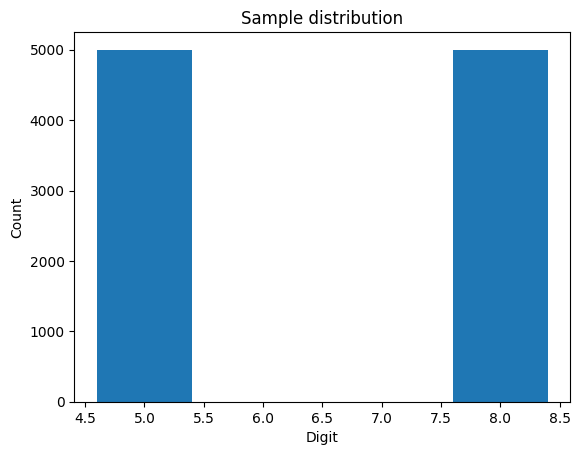

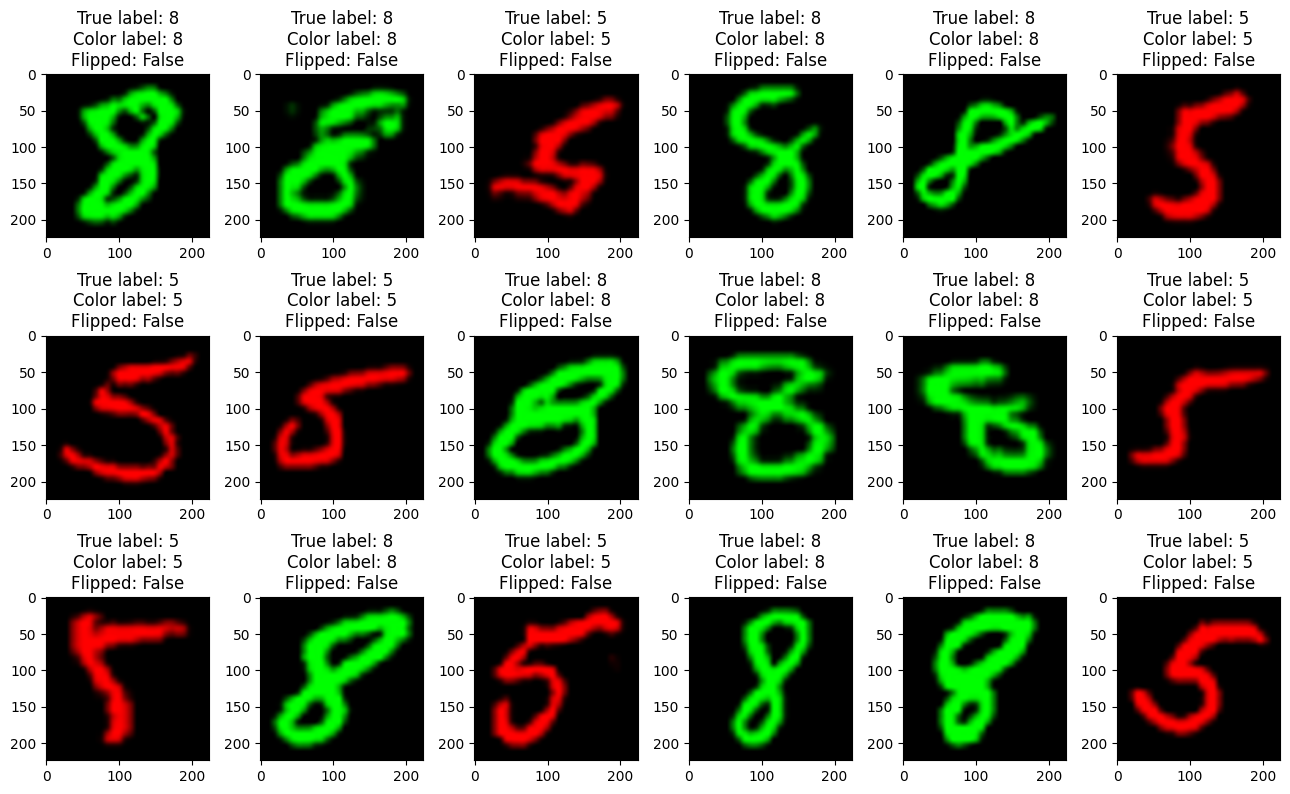

In [11]:
from torchvision import transforms

# initialize dataset
train_set = DatasetMNIST(root='/mnt/data/pa_finance/clip/data',
                            env='train',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=clip_preprocess,
                            test_fool_random=DATASET_TEST_FOOL_RANDOM_COLORS,
                            transform= transforms.Compose([transforms.ToTensor()]))

# create dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

print(f"Number of training samples: {len(train_loader.dataset.data_label_tuples)}")
digit_distribution(train_set)
plot_digits(train_set, clip_preprocess)

# layer matching

In [12]:
def save_array(array, filename):
    open_file = open(filename, "wb")
    pickle.dump(array, open_file)
    open_file.close()

In [13]:
def store_activs(model, layers):
    activs = []
    for layer in layers:
        activation = model.retained_layer(layer, clear = True)
        activs.append(activation)
        
    return activs

In [14]:
def dict_layers(activs):
    all_layers = {}
    for iii, activ in enumerate(activs):
        all_layers[activs[iii]] = activ.shape[1]
    return all_layers

In [15]:
def normalize(activation, stats_table):
    eps = 0.00001
    asdf1 = (activation- stats_table[0])
    asdf2 = (stats_table[1]+eps)
    norm_input = asdf1 / asdf2
    
    return norm_input

In [16]:
def create_final_table(all_match_table, model1_dict, model2_dict, batch_size, device ):
    num_activs1 = sum(model1_dict.values())
    num_activs2 = sum(model2_dict.values())
    final_match_table = torch.zeros((num_activs1, num_activs2)).to(device)
    
    model1_activ_count = 0 
    for ii in range(len(all_match_table)):
        model2_activ_count = 0
        for jj in range(len(all_match_table[ii])):
            num_model1activs = all_match_table[ii][0].shape[0]
            num_model2activs = all_match_table[0][jj].shape[1]
            final_match_table[model1_activ_count: model1_activ_count+num_model1activs, \
                            model2_activ_count:model2_activ_count+num_model2activs] = all_match_table[ii][jj]
            model2_activ_count += num_model2activs
        model1_activ_count += num_model1activs
    return final_match_table

In [17]:
from torchvision import transforms
from utils import nethook

def activation_matching(model1, model1_layers, model1_statistics_table, model2, model2_layers, model2_statistics_table, preprocessor, dataloader, batch_size, device):
    
    model1.eval()
    model2.eval()
    
    # hook layers for model 1
    model1 = nethook.InstrumentedModel(model1)
    model1.retain_layers(model1_layers)
    
    # hook layers for model 2
    model2 = nethook.InstrumentedModel(model2)
    model2.retain_layers(model2_layers)
    
    for iteration, data in enumerate(dataloader):
        with torch.no_grad():

            # copy data to GPU
            inputs, _, _, _ = data
            inputs = inputs.to(device)
            
            print(f"Batch {iteration} is being processed...")
            
            # inference first model
            _ = model1(inputs)
            
            # append model 1 layer-activations for batch
            model1_activations = store_activs(model1, model1_layers)

            # preprocess images
            transform = transforms.ToPILImage()
            images_new = []
            for img in inputs:
                images_new.append(preprocessor(transform(img)))

            # building image features
            images = torch.tensor(np.stack(images_new)).cuda()
            
            # inference second model
            _ = model2.model.encode_image(images)

            # append model 2 layer-activations for batch
            model2_activations =  store_activs(model2, model2_layers)

            # create dictionary of layers with number of activations
            all_model1_layers = dict_layers(model1_activations)
            all_model2_layers = dict_layers(model2_activations)
            
            if iteration == 0:
                num_model1_activations = sum(all_model1_layers.values())
                num_model2_activations = sum(all_model2_layers.values())
                final_match_table = torch.zeros((num_model1_activations, num_model2_activations)).to(device)

            # matching
            all_match_table = []

            for ii, model1_activation in enumerate(model1_activations):
                match_table = []
                model1_activation = normalize(model1_activation, model1_statistics_table[ii])
                model1_activation_shape = model1_activation.shape

                for jj, model2_activation in enumerate(model2_activations):
                    model2_activation_scaled = normalize(model2_activation, model2_statistics_table[jj]) 
                    # scale maps to same size
                    map_size = max((model1_activation_shape[2], model2_activation.shape[2]))
                    model1_activation_scaled = torch.nn.Upsample(size=(map_size,map_size), mode='bilinear')(model1_activation)
                    model2_activation_scaled = torch.nn.Upsample(size=(map_size,map_size), mode='bilinear')(model2_activation_scaled)            
                    scores = torch.einsum('aixy,ajxy->ij', model1_activation_scaled, model2_activation_scaled)/(batch_size*map_size**2)  
                    scores = scores.cpu()
                    
                    match_table.append(scores)
                    del model1_activation_scaled
                    del model2_activation_scaled
                    del scores
                    
                all_match_table.append(match_table)
                del match_table

            # create table
            batch_match_table = create_final_table(all_match_table, all_model1_layers, all_model2_layers, batch_size, device)
            final_match_table += batch_match_table
            save_array(final_match_table, "/mnt/data/pa_finance/clip/data/results/norm_table_"+str(iteration)+".pkl")
        
            del all_match_table
            del batch_match_table
            del model1_activations
            del model2_activations
            torch.cuda.empty_cache()
            
    # average and save
    final_match_table /= len(dataloader)
    save_array(final_match_table, "/mnt/data/pa_finance/clip/data/results/table.pkl")

In [18]:
def load_stats(root, device):

    # load table
    file_name = os.path.join(root, "table.pkl")
    with open(file_name, 'rb') as f:
        table = pickle.load(f)
        table = table.to(device)#cpu()
    
    # load statistics from model 1
    with open(os.path.join(root,"model1_statistics.pkl"), 'rb') as f:
        model1_statistics = pickle.load(f)
        for iii, item1 in enumerate(model1_statistics):
            for jjj, item2 in enumerate(model1_statistics[iii]):
                model1_statistics[iii][jjj] = model1_statistics[iii][jjj].to(device)
                
    # load statistics from model 2
    with open(os.path.join(root,"model2_statistics.pkl"), 'rb') as f:
        model2_statistics = pickle.load(f)
        
        for iii, item1 in enumerate(model2_statistics):
            for jjj, item2 in enumerate(model2_statistics[iii]):
                model2_statistics[iii][jjj] = model2_statistics[iii][jjj].to(device)
        
    return table, model1_statistics, model2_statistics

In [19]:
table, model1_statistics, model2_statistics = load_stats("/mnt/data/pa_finance/clip/data/results", device)

In [20]:
activation_matching(standalone_model, standalone_layers, model1_statistics,
                    clip_model, clip_layers, model2_statistics,
                    clip_preprocess, train_loader, DATASET_BATCH_SIZE, device)

Batch 0 is being processed...
Batch 1 is being processed...
Batch 2 is being processed...
Batch 3 is being processed...
Batch 4 is being processed...
Batch 5 is being processed...
Batch 6 is being processed...
Batch 7 is being processed...
Batch 8 is being processed...
Batch 9 is being processed...
Batch 10 is being processed...
Batch 11 is being processed...


In [25]:
table, model1_statistics, model2_statistics = load_stats("/mnt/data/pa_finance/clip/data/results", device)

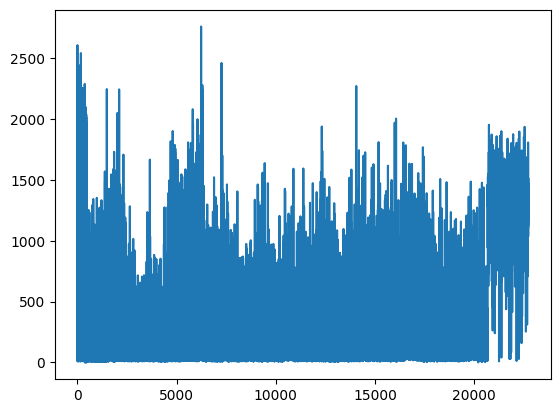

In [26]:
match_scores,_ = torch.max(table, 1)

plt.plot(match_scores.cpu().numpy())
plt.show()